# MNIST Classifier — Setup & Reproducibility

This notebook trains a simple MNIST classifier with PyTorch. The next cell will:
- Set deterministic seeds for reproducibility
- Print key package versions and device info
- Optionally configure backends for better determinism

In [ ]:
# Environment and seed setup
import os, random, platform
import numpy as np

SEED = int(os.environ.get("SEED", 42))

random.seed(SEED)
np.random.seed(SEED)

try:
    import torch
    import torchvision
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    # Optional determinism (may slightly slow down training)
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass
    import torch.backends.cudnn as cudnn
    cudnn.deterministic = True
    cudnn.benchmark = False

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    print(f"torch=={torch.__version__}, torchvision=={torchvision.__version__}")
except Exception as e:
    print("Torch/TorchVision not available yet:", e)

import sys
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("Seed:", SEED)

## Data availability
If MNIST is not present in `./data`, the next cell will download it using `torchvision.datasets.MNIST`.

In [ ]:
# Ensure MNIST is available under ./data using TorchVision
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

try:
    import torchvision
    from torchvision import datasets, transforms

    _ = datasets.MNIST(
        root=str(DATA_DIR),
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    )
    _ = datasets.MNIST(
        root=str(DATA_DIR),
        train=False,
        download=True,
        transform=transforms.ToTensor(),
    )
    print("MNIST is ready in ./data")
except Exception as e:
    print("Could not prepare MNIST via TorchVision:", e)

# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [21]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 78 kB 1.3 MB/s eta 0:00:011
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


**Important: Restart the Kernel at this moment**

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
m_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
# Create training set and define training dataloader
train = torchvision.datasets.MNIST(root='./data', train=True,
                                   download=True, transform=m_transform)
train_loader = DataLoader(train, batch_size=64)
# Create test set and define test dataloader
test = torchvision.datasets.MNIST(root='./data', train=False, 
                                  download=True, transform=m_transform)
test_loader = DataLoader(test, batch_size=500)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I used two transforms as following: 
- ToTensor(): which takes the each MNIST data from an image with pixel values ranging from 0 to 255 into a PyTorch tensor since neural networks works with tensors.
- Normalize((0.1307,), (0.3081,)): which standarizes the pixel values subtracting the dataset mean and dividing by its std. to center the data around 0, I got the mean and std of the dataset from online searching.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


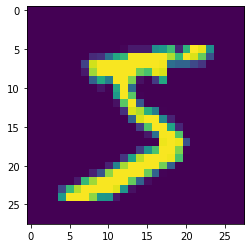

0


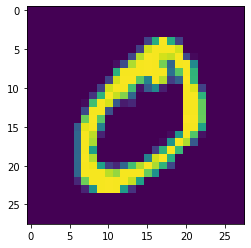

4


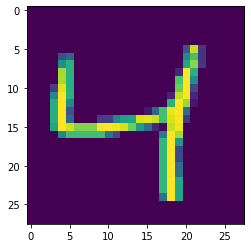

1


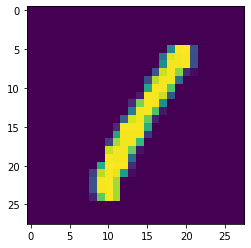

9


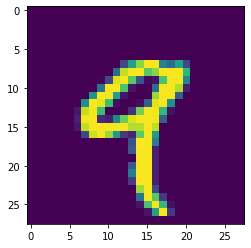

In [5]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
model_1 = NN()

loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.01)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
epochs = 5
train_losses = []
for epoch in range(epochs):
    running_loss = 0.00
    
    for batch_id, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model_1(images)
        loss = loss_f(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if (batch_id + 1) % 250 == 0:
            print(f"Epoch [{epoch + 1}], Step [{batch_id +1}/{len(train_loader)}], Loss: {loss.item()}")
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}")

Epoch [1], Step [250/938], Loss: 0.42548662424087524
Epoch [1], Step [500/938], Loss: 0.46771755814552307
Epoch [1], Step [750/938], Loss: 0.5394132733345032
Epoch [1/5] Average Loss: 0.2537
Epoch [2], Step [250/938], Loss: 0.14524367451667786
Epoch [2], Step [500/938], Loss: 0.15327447652816772
Epoch [2], Step [750/938], Loss: 0.21965119242668152
Epoch [2/5] Average Loss: 0.2135
Epoch [3], Step [250/938], Loss: 0.13419422507286072
Epoch [3], Step [500/938], Loss: 0.3476611375808716
Epoch [3], Step [750/938], Loss: 0.3218114972114563
Epoch [3/5] Average Loss: 0.2074
Epoch [4], Step [250/938], Loss: 0.2964703440666199
Epoch [4], Step [500/938], Loss: 0.2636520564556122
Epoch [4], Step [750/938], Loss: 0.3125521242618561
Epoch [4/5] Average Loss: 0.1966
Epoch [5], Step [250/938], Loss: 0.152130126953125
Epoch [5], Step [500/938], Loss: 0.30677077174186707
Epoch [5], Step [750/938], Loss: 0.1336641013622284
Epoch [5/5] Average Loss: 0.1815


Plot the training loss (and validation loss/accuracy, if recorded).

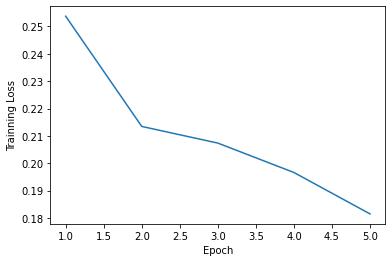

In [18]:
plt.plot([1,2,3,4,5], train_losses)
plt.xlabel('Epoch')
plt.ylabel('Trainning Loss')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [20]:
correct = 0
total = 0

model_1.eval()

with torch.no_grad():
    for images, labels in test_loader:
        output = model_1(images)
        _, prediction = torch.max(output, 1)
        total += labels.size(0)
        correct += (prediction == labels).sum().item()
print(f" Accuracy = {100 * (correct/total)}")

 Accuracy = 93.53


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

Epoch [1], Step [250/938], Loss: 0.31820961833000183
Epoch [1], Step [500/938], Loss: 0.16133220493793488
Epoch [1], Step [750/938], Loss: 0.19923974573612213
Epoch [1/5] Average Loss: 0.2425
Epoch [2], Step [250/938], Loss: 0.12327881157398224
Epoch [2], Step [500/938], Loss: 0.07755903899669647
Epoch [2], Step [750/938], Loss: 0.1450892686843872
Epoch [2/5] Average Loss: 0.1024
Epoch [3], Step [250/938], Loss: 0.08200258016586304
Epoch [3], Step [500/938], Loss: 0.03737587481737137
Epoch [3], Step [750/938], Loss: 0.14405930042266846
Epoch [3/5] Average Loss: 0.0721
Epoch [4], Step [250/938], Loss: 0.1237848699092865
Epoch [4], Step [500/938], Loss: 0.03547997772693634
Epoch [4], Step [750/938], Loss: 0.11218103766441345
Epoch [4/5] Average Loss: 0.0567
Epoch [5], Step [250/938], Loss: 0.0790976956486702
Epoch [5], Step [500/938], Loss: 0.023947959765791893
Epoch [5], Step [750/938], Loss: 0.07221062481403351
Epoch [5/5] Average Loss: 0.0444


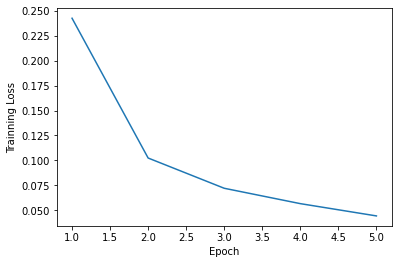

 Accuracy = 97.04


In [7]:
# Adding more hidden layers and adjust the learning_rate to be 0.001
class NN_2(nn.Module):
    def __init__(self):
        super(NN_2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model_2 = NN_2()
loss_f_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)


################ Training ##########
epochs = 5
train_losses = []

for epoch in range(epochs):
    running_loss = 0.00
    
    for batch_id, (images, labels) in enumerate(train_loader):
        optimizer_2.zero_grad()
        outputs = model_2(images)
        loss = loss_f_2(outputs, labels)
        loss.backward()
        optimizer_2.step()
        running_loss += loss.item()
        
        if (batch_id + 1) % 250 == 0:
            print(f"Epoch [{epoch + 1}], Step [{batch_id +1}/{len(train_loader)}], Loss: {loss.item()}")
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}")
plt.plot([1,2,3,4,5], train_losses)
plt.xlabel('Epoch')
plt.ylabel('Trainning Loss')
plt.show()
################ Testing ##########
correct_2 = 0
total_2 = 0

model_2.eval()

with torch.no_grad():
    for images, labels in test_loader:
        output = model_2(images)
        _, prediction = torch.max(output, 1)
        total_2 += labels.size(0)
        correct_2 += (prediction == labels).sum().item()
print(f" Accuracy = {100 * (correct_2/total_2)}")


## Saving your model
Using `torch.save`, save your model for future loading.

In [8]:
torch.save(model_2.state_dict(), "mnist_model.pth")